# Neural Network Assignment
## DO NOT SUBMIT JUST FOR BETTER FUNCTIONALITY
*by Lethabo Neo* 

# Imports, Installations and Downloads

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, io
from torch.utils.data import DataLoader, Dataset,random_split
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import random

# Data Processing
- Reading files from directory
- Converting the images into vectors
- Displaying the images
- Subsetting the data
- Assigning the kind of data to labels

1. Read files from directory

In [4]:
DATA_DIR = "/Users/lethaboneo/Desktop/Computer Science/CSC3022F/Assignments/Machine Learning/ML Assignment 1/"
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
train = datasets.FashionMNIST(DATA_DIR, train=True, download=False, transform=transform)
test = datasets.FashionMNIST(DATA_DIR, train=False, download=False,transform=transform)

*Visualisation purposes*
*print the datasets*

In [ ]:
print("Train dataset:", train)

print("Test dataset:", test)


In [ ]:
train_size= int(0.9*len(train))
val_size= len(train)- train_size
trainData, valData = random_split(train,[train_size,val_size])
print("Training Dataset:", trainData)
print("Validation Dataset:", valData)
print("Test Dataset:", test)

Split data into Training/Validation/Test sets


In [ ]:
# Create data loaders
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=trainData, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valData, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


# Neural Network implementation
Classification function

In [21]:
input_size = 28*28
hidden_layers = 256
num_classes = 10

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(NeuralNetwork,self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_layers)
        self.bn1= nn.BatchNorm1d(hidden_layers)
        self.dropout=nn.Dropout(0.5)
        self.relu =nn.ReLU()
        self.fc2 = nn.Linear(hidden_layers,num_classes)

    def forward(self,x):
        out =self.fc1(x)
        out =self.bn1(out)
        out= self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
        
model = NeuralNetwork(input_size, hidden_layers,num_classes)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


# Train model


In [39]:
learn_rate = 0.001
num_epochs = 30
best_val_acc = 0
train_loss = []
val_loss = []
val_acc = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learn_rate,weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=2,factor=0.5)

# Validation phase

In [40]:

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.reshape(-1, input_size)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate epoch training loss
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_loss_epoch = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.reshape(-1, input_size)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate validation metrics
    val_loss_epoch /= len(val_loader)
    val_loss.append(val_loss_epoch)
    val_accuracy = 100 * correct / total
    val_acc.append(val_accuracy)
    
    # Update learning rate
    scheduler.step(val_accuracy)
    
    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'best_model_nn.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Val Loss: {val_loss_epoch:.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}% '
          f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

Epoch [1/30], Train Loss: 0.2822, Val Loss: 0.3086, Val Accuracy: 88.72% LR: 0.001000
Epoch [2/30], Train Loss: 0.2806, Val Loss: 0.3137, Val Accuracy: 88.51% LR: 0.001000
Epoch [3/30], Train Loss: 0.2759, Val Loss: 0.3062, Val Accuracy: 88.92% LR: 0.001000
Epoch [4/30], Train Loss: 0.2720, Val Loss: 0.3085, Val Accuracy: 88.75% LR: 0.001000
Epoch [5/30], Train Loss: 0.2701, Val Loss: 0.3081, Val Accuracy: 88.86% LR: 0.001000
Epoch [6/30], Train Loss: 0.2645, Val Loss: 0.3074, Val Accuracy: 88.89% LR: 0.000500
Epoch [7/30], Train Loss: 0.2402, Val Loss: 0.2951, Val Accuracy: 89.58% LR: 0.000500
Epoch [8/30], Train Loss: 0.2296, Val Loss: 0.2973, Val Accuracy: 89.53% LR: 0.000500
Epoch [9/30], Train Loss: 0.2285, Val Loss: 0.2941, Val Accuracy: 89.68% LR: 0.000500
Epoch [10/30], Train Loss: 0.2236, Val Loss: 0.2984, Val Accuracy: 89.39% LR: 0.000500
Epoch [11/30], Train Loss: 0.2178, Val Loss: 0.2969, Val Accuracy: 89.72% LR: 0.000500
Epoch [12/30], Train Loss: 0.2200, Val Loss: 0.3012,

In [41]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

print("\nFinal Evaluation:")
val_accuracy = evaluate_model(model, val_loader)
test_accuracy = evaluate_model(model, test_loader)
print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')


Final Evaluation:
Validation Accuracy: 90.23%
Test Accuracy: 90.01%


# Graphs

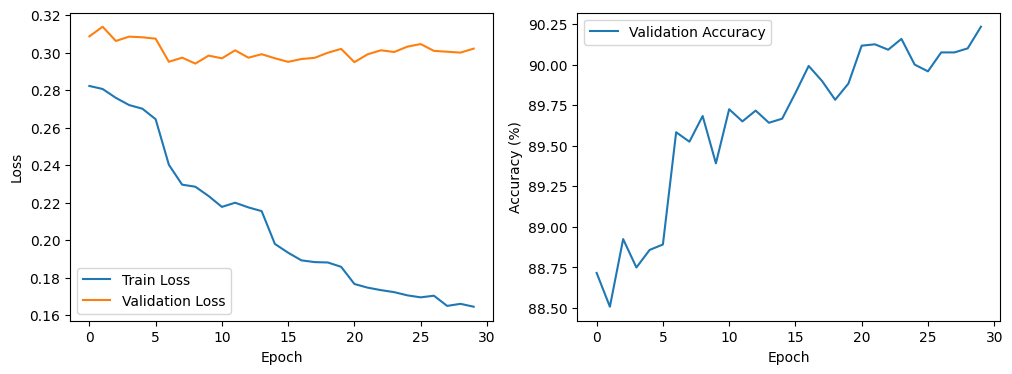

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Validation Set Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.87      1238
     Trouser       0.99      0.98      0.98      1131
    Pullover       0.83      0.84      0.83      1267
       Dress       0.90      0.93      0.91      1193
        Coat       0.82      0.85      0.84      1208
      Sandal       0.97      0.97      0.97      1211
       Shirt       0.75      0.71      0.73      1216
     Sneaker       0.95      0.96      0.96      1197
         Bag       0.98      0.97      0.98      1180
  Ankle boot       0.97      0.96      0.96      1159

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000


Test Set Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.85      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pu

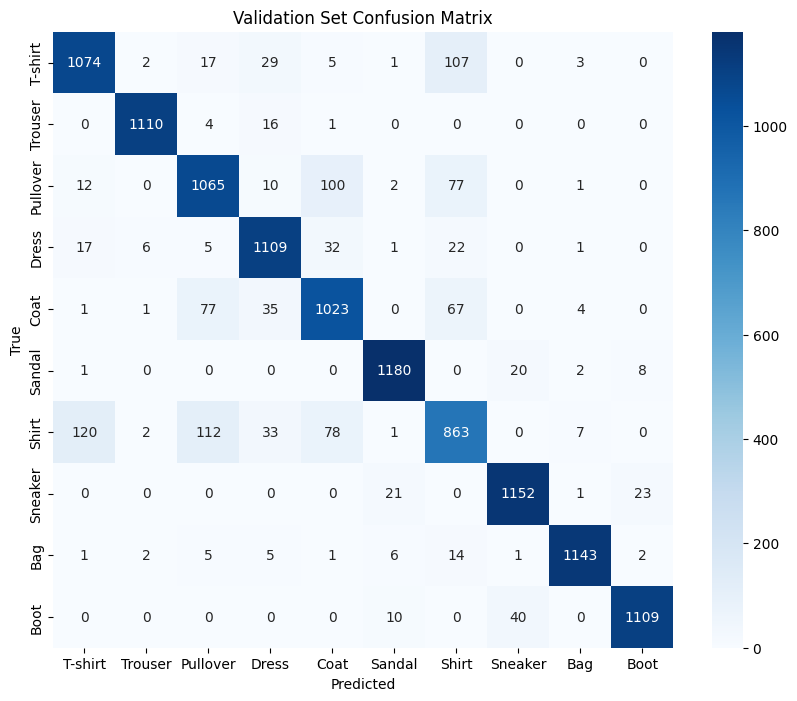


Test Set Confusion Matrix:


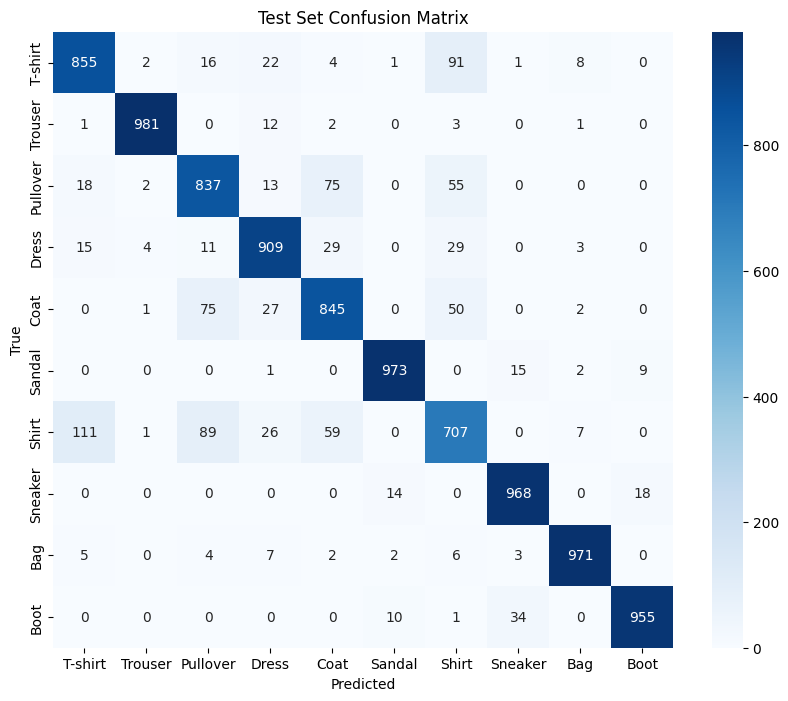

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
def evaluate_model_comprehensive(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# Get predictions for validation set
val_labels, val_preds = evaluate_model_comprehensive(model, val_loader)

# Get predictions for test set
test_labels, test_preds = evaluate_model_comprehensive(model, test_loader)

# Classification Report
print("\nValidation Set Classification Report:")
print(classification_report(val_labels, val_preds, target_names=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]))

print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]))

# Confusion Matrix Visualization
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=[
                    'T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot'
                ],
                yticklabels=[
                    'T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot'
                ])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print("\nValidation Set Confusion Matrix:")
plot_confusion_matrix(val_labels, val_preds, "Validation Set Confusion Matrix")

print("\nTest Set Confusion Matrix:")
plot_confusion_matrix(test_labels, test_preds, "Test Set Confusion Matrix")
